Import Packages and Load Data


In [1]:
!pip3 install prophet

zsh:1: command not found: pip


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import levene
from scipy.stats import mannwhitneyu
import scipy.stats as stats
from prophet import Prophet
import matplotlib.dates as mdates


# Read the excel file
df = pd.read_excel('/Users/Will/Bane Assessment/BCV-ds-consultant-take-home-v2.xlsx')

df['fintech'] = np.where(df['CATEGORY_LIST'].str.contains('FinTech',na=False),'Fintech','Not Fintech')


Importing plotly failed. Interactive plots will not work.


Test hypothesis - Are FinTech Startups Better funded?

Take a look at summary statistics and box and whisker plot to see basic overview of Fintech/Non-Fintech.

In [17]:
print(df.groupby('fintech')['TOTAL_FUNDING'].describe())


               count          mean           std  min        25%         50%   
fintech                                                                        
Fintech       1774.0  4.191059e+07  1.096801e+08  0.0  3035000.0  11000000.0  \
Not Fintech  20527.0  3.232960e+07  2.790870e+08  0.0  1250000.0   6000000.0   

                    75%           max  
fintech                                
Fintech      36925000.0  2.292603e+09  
Not Fintech  22000000.0  2.100000e+10  


In [ ]:
from scipy.stats import ttest_ind

fintech_funding = df[df['fintech'] == 'Fintech']['TOTAL_FUNDING'].dropna()
non_fintech_funding = df[df['fintech'] == 'Not Fintech']['TOTAL_FUNDING'].dropna()

t_stat, p_value = ttest_ind(fintech_funding, non_fintech_funding, equal_var=True) #since Levene's p-value is >0.05 I've set equal val to True
print(f"T-test p-value: {p_value}")

T-test p-value: 0.15091611860095375


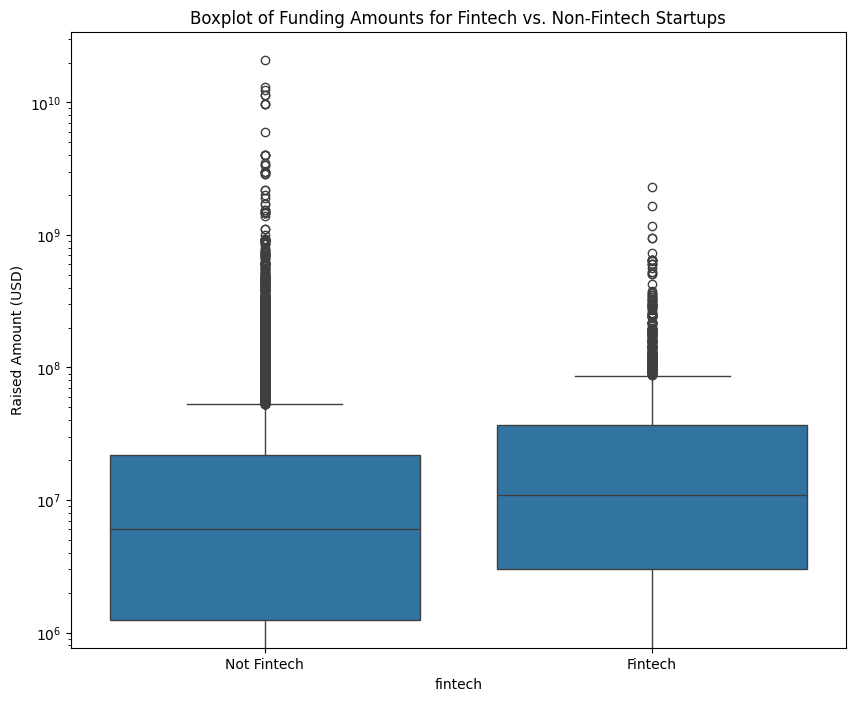

In [41]:
import scipy.stats as stats

plt.figure(figsize=(10, 8))

box_plot = sns.boxplot(x='fintech', y='TOTAL_FUNDING', data=df)
plt.title('Boxplot of Funding Amounts for Fintech vs. Non-Fintech Startups')
plt.ylabel('Raised Amount (USD)')
plt.yscale('log') ##use log scale because of the magnitude of difference
plt.show()


Analyize differences of variance between fintech and non fintech

In [33]:
stat, p = levene(fintech_funding, non_fintech_funding)
print(f"Levene's p-value: {p}")

if p < 0.05:
    print("Variances are significantly different.")
else:
    print("Variances are not significantly different.")


Levene's p-value: 0.24562683420223994
Variances are not significantly different.


T-test to determine Statistical Significance



In [45]:
from scipy.stats import ttest_ind

fintech_funding = df[df['fintech'] == 'Fintech']['TOTAL_FUNDING'].dropna()
non_fintech_funding = df[df['fintech'] == 'Not Fintech']['TOTAL_FUNDING'].dropna()

t_stat, p_value = ttest_ind(fintech_funding, non_fintech_funding, equal_var=True) #since Levene's p-value is >0.05 I've set equal val to True
print(f"T-test p-value: {p_value}")

T-test p-value: 0.15091611860095375


Histogram to assess normality

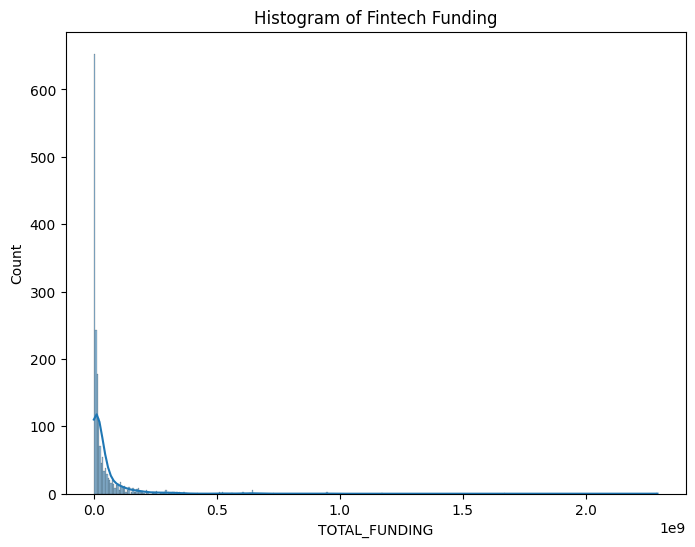

In [49]:
plt.figure(figsize=(8, 6))
sns.histplot(fintech_funding, kde=True)
plt.title('Histogram of Fintech Funding')
plt.show()

Since distribution is clearly skewed, conduct Mann-Whitney test

In [ ]:

result = mannwhitneyu(fintech_funding, non_fintech_funding, alternative='two-sided')

print(f"U statistic: {result.statistic}")
print(f"P-value: {result.pvalue}")

Summarize Median difference

In [46]:
median_difference = fintech_funding.median() - non_fintech_funding.median()

percentage_difference = (median_difference / non_fintech_funding.median()) * 100
print(percentage_difference)


83.33333333333334


Seasonality Anaysis

In [83]:
df.LAST_FUNDING_ON = pd.to_datetime(df.LAST_FUNDING_ON)

In [ ]:
df.TOTAL_FUNDING_USD

21:38:22 - cmdstanpy - INFO - Chain [1] start processing
21:38:22 - cmdstanpy - INFO - Chain [1] done processing


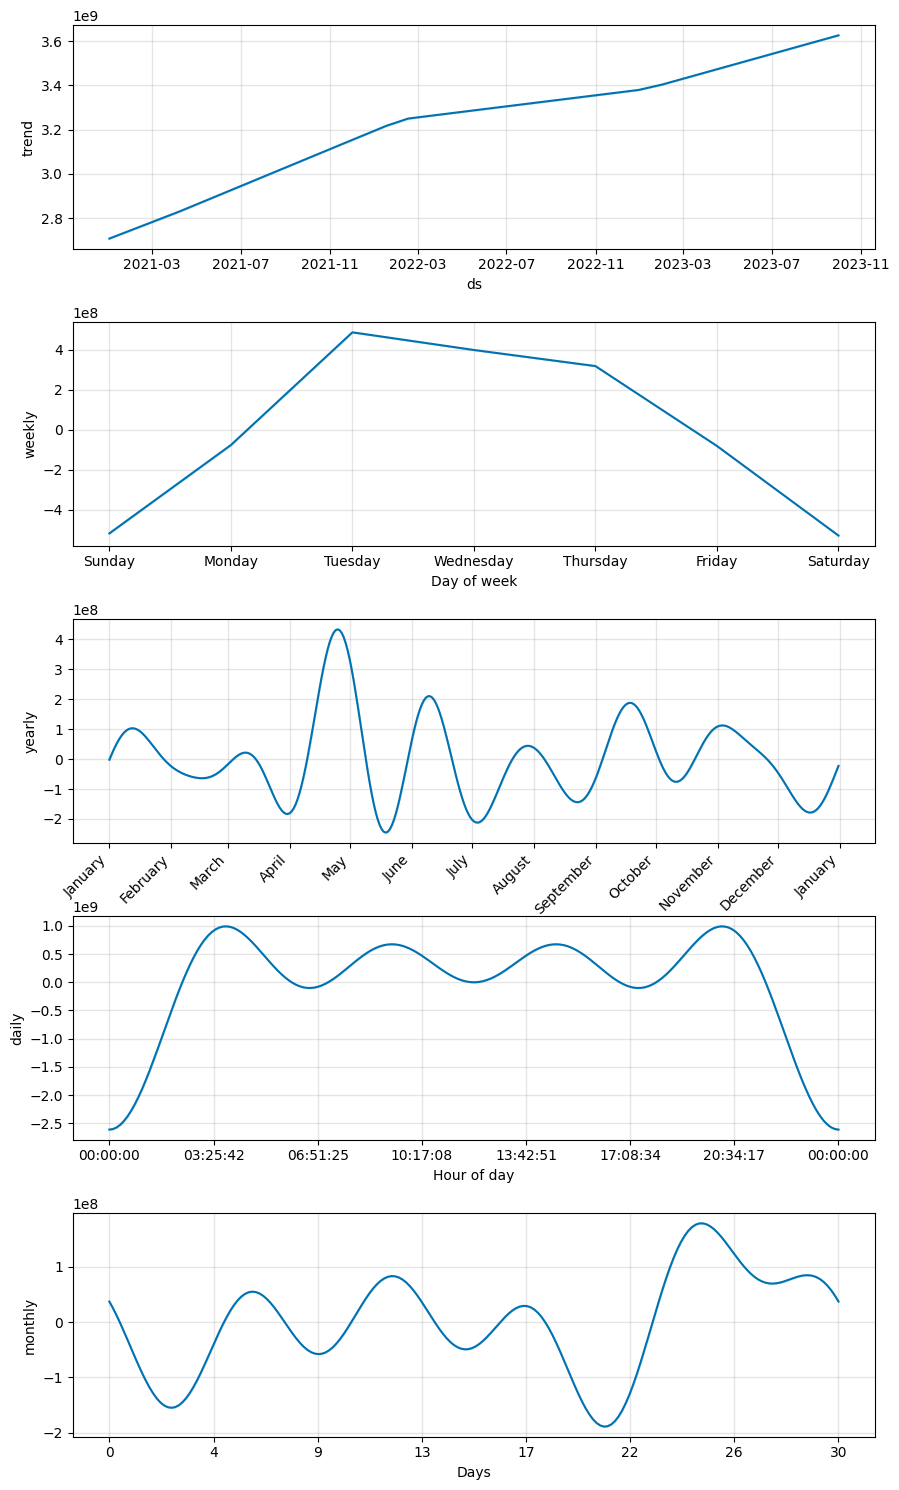

In [10]:

df_aggregated = df.groupby('LAST_FUNDING_ON').agg({'TOTAL_FUNDING_USD':'sum'}).reset_index()

df_aggregated.columns = ['ds', 'y']

# Initialize and fit the model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.add_seasonality(name='monthly', period=30.44, fourier_order=5) 
model.fit(df_aggregated)
# Make predictions
forecast = model.predict(df_aggregated)

fig = model.plot_components(forecast)

ax = fig.get_axes()[2]  

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.show()